In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [62]:
path = '/home/nguu0123/git/thesis/ray_deployment/logs/'
inference_log = pd.read_csv(path + 'inference_log.csv')
models_log    = pd.read_csv(path + 'models_log.csv')
request_log   = pd.read_csv(path + 'request_log.csv')
server_log    = pd.read_csv(path + 'server_log.csv')
classes       = ['bicycle', 'car', 'cat', 'dog', 'person']

In [63]:
def get_average(data, windows):
    return data.rolling(windows).mean().tolist()[windows - 1:]

<AxesSubplot: >

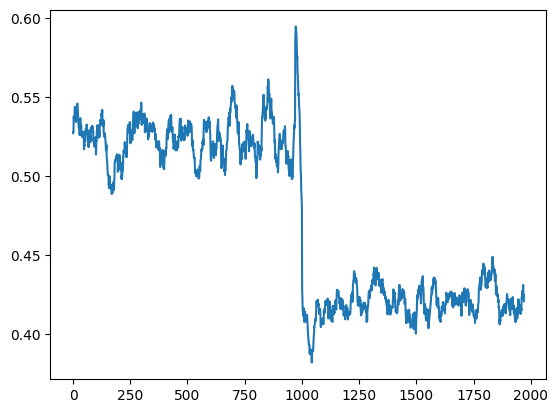

In [64]:
average_request_time_response = get_average(request_log['Response time'], 30)
sns.lineplot(y=average_request_time_response, x=range(len(average_request_time_response)))

<AxesSubplot: >

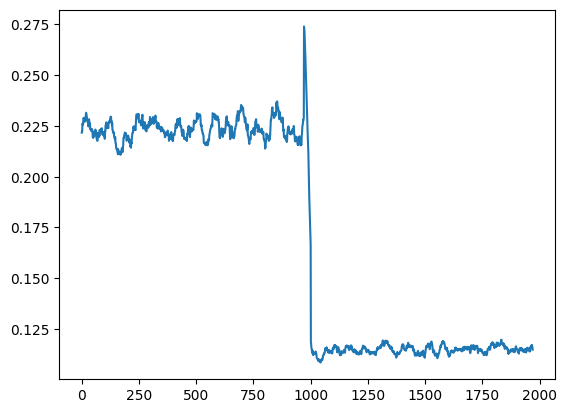

In [65]:
average_inference_time = get_average(server_log['Response time'], 30)
sns.lineplot(y=average_inference_time, x=range(len(average_inference_time)))

In [66]:
yolo5n = inference_log[(inference_log["Model"] == 'yolov5n') & (inference_log["Class"] == 'cat')]
yolo5n['Object width'] * yolo5n['Object height']

2894         0.000000
2900    268333.278706
2936         0.000000
2939         0.000000
2956         0.000000
            ...      
5391    268155.407270
5410         0.000000
5504         0.000000
5507     56185.787161
5513    103914.161193
Length: 113, dtype: float64

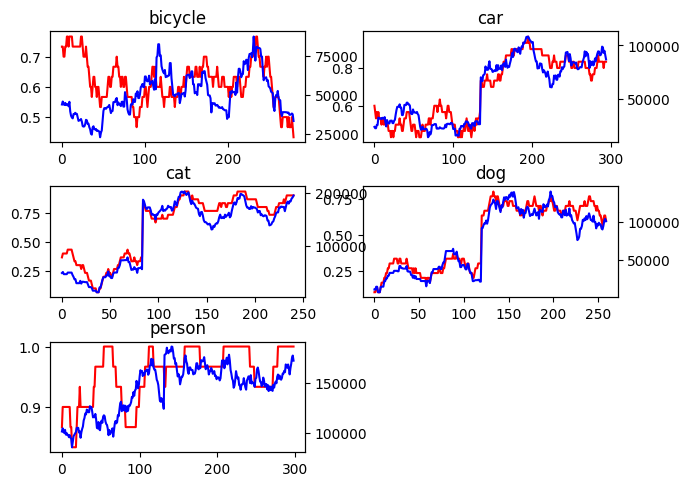

In [67]:
fig, axs = plt.subplots(3, 2)
fig.tight_layout()
fig.delaxes(axs[2][1])
i = 0 
j = 0
for cur_class in classes:
    yolo5n = inference_log[(inference_log["Model"] == 'yolov5n') & (inference_log["Class"] == cur_class)]
    yolo5s =  inference_log[(inference_log["Model"] == 'yolov5s') & (inference_log["Class"] == cur_class)]
    yolo5n_accuracy = get_average(yolo5n["Correctly detect"],30)
    yolo5s_accuracy = get_average(yolo5s["Correctly detect"],30)
    combined_accuracy = yolo5n_accuracy + yolo5s_accuracy
    average_object_size_yolo5n = get_average(yolo5n['Object width'] * yolo5n['Object height'], 30)
    average_object_size_yolo5s = get_average(yolo5s['Object width'] * yolo5s['Object height'], 30)
    average_object_size = average_object_size_yolo5n + average_object_size_yolo5s
    sns.lineplot(y=combined_accuracy, x=range(len(combined_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_size, x=range(len(average_object_size)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1


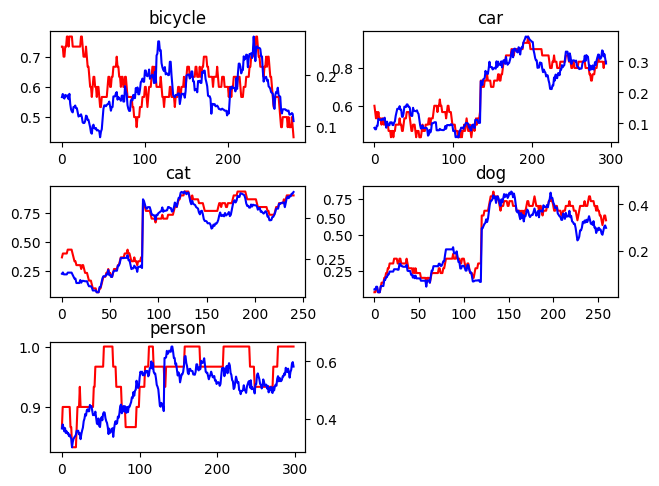

In [68]:
fig, axs = plt.subplots(3, 2)
fig.delaxes(axs[2][1])
fig.tight_layout()
i = 0 
j = 0
for cur_class in classes:
    yolo5n = inference_log[(inference_log["Model"] == 'yolov5n') & (inference_log["Class"] == cur_class)]
    yolo5s =  inference_log[(inference_log["Model"] == 'yolov5s') & (inference_log["Class"] == cur_class)]
    yolo5n_accuracy = get_average(yolo5n["Correctly detect"],30)
    yolo5s_accuracy = get_average(yolo5s["Correctly detect"],30)
    combined_accuracy = yolo5n_accuracy + yolo5s_accuracy
    average_object_percentage_yolo5n = get_average(yolo5n['Object to Image percentage'], 30)
    average_object_percentage_yolo5s = get_average(yolo5s['Object to Image percentage'], 30)
    average_object_percentage = average_object_percentage_yolo5n + average_object_percentage_yolo5s
    sns.lineplot(y=combined_accuracy, x=range(len(combined_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_percentage, x=range(len(average_object_percentage)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1



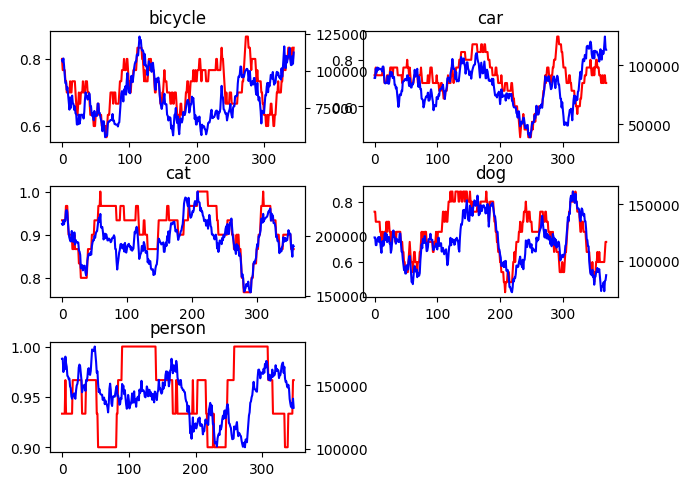

In [69]:
fig, axs = plt.subplots(3, 2)
fig.delaxes(axs[2][1])
fig.tight_layout()
i = 0 
j = 0
for cur_class in classes:
    yolo8n = inference_log[(inference_log["Model"] == 'yolov8n') & (inference_log["Class"] == cur_class)]
    yolo8n_accuracy = get_average(yolo8n["Correctly detect"],30)
    average_object_size = get_average(yolo8n['Object width'] * yolo8n['Object height'], 30)
    sns.lineplot(y=yolo8n_accuracy, x=range(len(yolo8n_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_size, x=range(len(average_object_size)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1

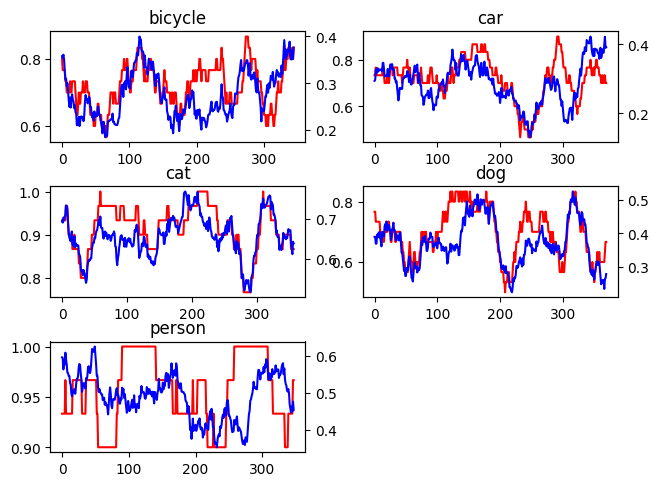

In [70]:
fig, axs = plt.subplots(3, 2)
fig.tight_layout()
i = 0 
j = 0
fig.delaxes(axs[2][1])
for cur_class in classes:
    yolo8n = inference_log[(inference_log["Model"] == 'yolov8n') & (inference_log["Class"] == cur_class)]
    yolo8n_accuracy = get_average(yolo8n["Correctly detect"],30)
    average_object_percentage_yolo8n = get_average(yolo8n['Object to Image percentage'], 30)
    sns.lineplot(y=yolo8n_accuracy, x=range(len(yolo8n_accuracy)), ax=axs[i][j], color='red')
    ax2 = axs[i][j].twinx()
    sns.lineplot(y=average_object_percentage_yolo8n, x=range(len(average_object_percentage_yolo8n)), ax=ax2, color='blue')
    axs[i][j].set_title(cur_class)
    j = (j + 1) % 2
    if j == 0:
        i += 1